In [7]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-1v3nwz5v
  Running command git clone --filter=blob:none -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-1v3nwz5v
  Resolved https://github.com/desi-bgs/bgs-cmxsv.git to commit 945522027464f69e072b98c21c594a20b6d40d6d
  Preparing metadata (setup.py) ... done


In [8]:
import os
import h5py
import fitsio
import numpy as np 
import scipy as sp
import astropy.table as atable
import astropy.units as u

from bgs_sv import sv1
from bgs_sv import obscond

In [9]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# Get SV1 exposures until September 28, 2021

In [10]:
fsky = '/global/cfs/cdirs/desi/users/chahah/sky_sv1/sv1.all_exps.20210928.Isky.npy'
fwave = '/global/cfs/cdirs/desi/users/chahah/sky_sv1/sv1.all_exps.20210928.wave.npy'
fobscond = '/global/cfs/cdirs/desi/users/chahah/sky_sv1/sv1.all_exps.20210928.obs_cond.hdf5'

gfa = atable.Table.read('/global/cfs/cdirs/desi/users/ameisner/GFA/conditions/offline_matched_coadd_ccds_SV1-thru_20210928.fits')['EXPID', 'MJD']#, 'SKY_MAG_AB', 'MOON_ILLUMINATION', 'MOON_SEP_DEG', 'MOON_ZD_DEG', 'TRANSPARENCY']
gfa = gfa.group_by(['EXPID']).groups.aggregate(np.median)

exps = atable.Table.read(fobscond, format='hdf5')
Iskies = np.load(fsky)
wave = np.load(fwave)

assert len(exps) == len(Iskies)

In [11]:
exps = atable.join(exps, gfa, keys=['EXPID', 'MJD'], join_type='left')

In [12]:
exps[:5]

MJD,NIGHT,EXPID,AIRMASS,SKY_MAG_AB,MOON_ILLUMINATION,MOON_SEP_DEG,MOON_ZD_DEG,TRANSPARENCY
float64,float64,int64,float64,float64,float64,float64,float64,float64
59198.08855637566,20201214.0,67678,1.0245214875180846,20.306343899519227,0.00241368938034363,117.73375330282161,107.18208872228597,0.9421358004271907
59198.09340272179,20201214.0,67679,1.0191465895617893,20.253945455193083,0.0024700775622045036,117.6702245451234,108.53487794245974,0.9031746394430591
59198.09831583536,20201214.0,67680,1.01446950715555,20.033265558674195,0.002528564919546986,117.60668865736183,109.91266545656522,0.9527972869199486
59198.10320283822,20201214.0,67681,1.0105723623262,20.218061565792368,0.002586841487755262,117.5431524606984,111.28808981011574,0.9507191598338869
59198.10810292036,20201214.0,67682,1.0074075191686402,20.202504822354022,0.0026464129287131835,117.47957321208305,112.6723796158372,0.9562083786822335


In [13]:
# get sun conditions 
sun_alt = []
for i, mjd in enumerate(exps['MJD']): 
    _, _, _sun_alt = obscond.get_sun(mjd)
    sun_alt.append(_sun_alt)
sun_alt = np.array(sun_alt)

In [14]:
# observing conditions from median value of the GFAs
airmass = exps['AIRMASS']
moon_frac = exps['MOON_ILLUMINATION']
moon_sep = exps['MOON_SEP_DEG']
moon_alt = 90. - exps['MOON_ZD_DEG']
transp = exps['TRANSPARENCY']

# only high transparencies with no sun
cut = (transp > 0.95) & (sun_alt < -18.)
print('%i of %i exposures have TRANSP > 0.95 and SUNALT < -18.' % (np.sum(cut), len(exps)))

airmass = airmass[cut]
moon_frac = moon_frac[cut]
moon_sep = moon_sep[cut]
moon_alt = moon_alt[cut]
transp = transp[cut]
sun_alt = sun_alt[cut]
Iskies = Iskies[cut,:]

2335 of 3836 exposures have TRANSP > 0.95 and SUNALT < -18.


In [15]:
len(airmass)

2335

[Text(0, -0.2, ''),
 Text(0, 0.0, ''),
 Text(0, 0.2, ''),
 Text(0, 0.4000000000000001, ''),
 Text(0, 0.6000000000000001, ''),
 Text(0, 0.8, ''),
 Text(0, 1.0000000000000002, ''),
 Text(0, 1.2000000000000002, '')]

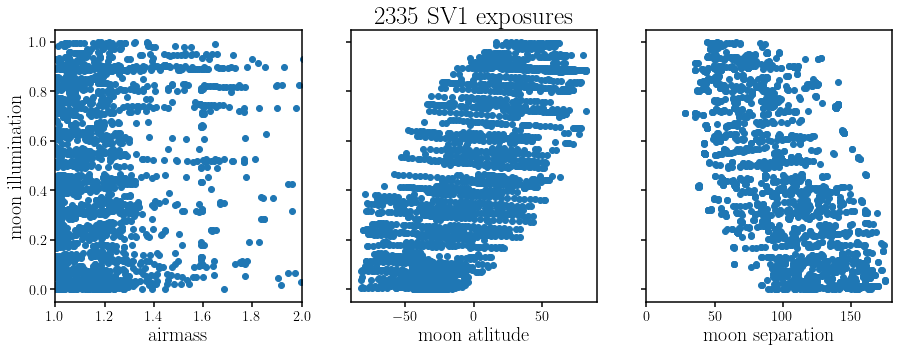

In [16]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(airmass, moon_frac, c='C0')
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(moon_alt, moon_frac, c='C0')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])
sub.set_title('%i SV1 exposures' % np.sum(cut), fontsize=25)

sub = fig.add_subplot(133)
sub.scatter(moon_sep, moon_frac, c='C0')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

# get BOSS and CMX skies
Lets supplement the SV1 sky data with sky observations from BOSS and CMX

In [17]:
dir_cmx = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'
dir_sky = '/global/cfs/cdirs/desi/users/chahah/sky/'

def read_cmx_skies(): 
    ''' read CMX sky fibers and return median sky surface brightness measurements for each exposure
    '''
    fsky = h5py.File(os.path.join(dir_cmx, 'sky_fibers.cmx.v1.hdf5'), 'r')
    
    sky_data = {}
    for k in fsky.keys():
        sky_data[k] = fsky[k][...]
    
    bad_seeing = (sky_data['tileid'] == 70502) | (sky_data['date'] == 20200314) #bad seeing on Feb 25 and 27

    exp_cuts = ~bad_seeing

    for k in sky_data.keys(): 
        if 'wave' not in k: 
            sky_data[k] = sky_data[k][exp_cuts]
        else:
            sky_data[k] = sky_data[k]
            
    uniq_exps, i_uniq = np.unique(sky_data['expid'], return_index=True)

    # compile median observing conditions for each unique exposure and
    # get the median sky fluxes of all sky fibers
    sky_uniq_exps = {} 
    for k in ['date', 'tileid', 'expid', 
              'airmass', 'moon_ill', 'moon_alt', 'moon_sep', 
              'sun_alt', 'sun_sep', 'exptime', 'transparency']: 
        sky_uniq_exps[k] = np.zeros(len(uniq_exps))

    sky_uniq_exps['wave_b'] = sky_data['wave_b']
    sky_uniq_exps['wave_r'] = sky_data['wave_r']
    sky_uniq_exps['wave_z'] = sky_data['wave_z']
    
    sky_uniq_exps['sky_b'] = np.zeros((len(uniq_exps), len(sky_data['wave_b'])))
    sky_uniq_exps['sky_r'] = np.zeros((len(uniq_exps), len(sky_data['wave_r'])))
    sky_uniq_exps['sky_z'] = np.zeros((len(uniq_exps), len(sky_data['wave_z'])))
    
    print('date \t\t tile \t exp \t texp \t airmass \t moon_ill \t moon_alt \t moon_sep')
    for _i, _i_uniq, _exp in zip(range(len(i_uniq)), i_uniq, uniq_exps): 
        _is_exp = (sky_data['expid'] == _exp)

        sky_uniq_exps['date'][_i] = sky_data['date'][_i_uniq]
        sky_uniq_exps['tileid'][_i] = sky_data['tileid'][_i_uniq]
        sky_uniq_exps['expid'][_i] = sky_data['expid'][_i_uniq]
        sky_uniq_exps['airmass'][_i] = np.median(sky_data['airmass'][_is_exp])
        sky_uniq_exps['moon_ill'][_i] = np.median(sky_data['moon_ill'][_is_exp])
        sky_uniq_exps['moon_alt'][_i] = np.median(sky_data['moon_alt'][_is_exp])
        sky_uniq_exps['moon_sep'][_i] = np.median(sky_data['moon_sep'][_is_exp])
        sky_uniq_exps['transparency'][_i] = np.median(sky_data['transparency'][_is_exp])

        sky_uniq_exps['exptime'][_i] = sky_data['exptime'][_is_exp][0]

        sky_uniq_exps['sun_alt'][_i] = np.median(sky_data['sun_alt'][_is_exp])
        sky_uniq_exps['sun_sep'][_i] = np.median(sky_data['sun_sep'][_is_exp])        


        sky_uniq_exps['sky_b'][_i] = np.median(sky_data['sky_sb_b'][_is_exp], axis=0) 
        sky_uniq_exps['sky_r'][_i] = np.median(sky_data['sky_sb_r'][_is_exp], axis=0) 
        sky_uniq_exps['sky_z'][_i] = np.median(sky_data['sky_sb_z'][_is_exp], axis=0)

        print('%i \t %i \t %i \t %.f \t %.2f \t\t %.2f \t\t %.1f \t\t %f' % 
              (sky_data['date'][_i_uniq], sky_data['tileid'][_i_uniq], sky_data['expid'][_i_uniq], 
               sky_uniq_exps['exptime'][_i], 
               sky_uniq_exps['airmass'][_i], sky_uniq_exps['moon_ill'][_i], 
               sky_uniq_exps['moon_alt'][_i], sky_uniq_exps['moon_sep'][_i]))

    return sky_uniq_exps

def read_BOSS_skies(): 
    ''' read sky fibers from BOSS
    '''
    f_boss = os.path.join(dir_sky, 'Bright_BOSS_Sky_blue.fits')
    boss = fitsio.read(f_boss)    
    f_red = os.path.join(dir_sky, 'Bright_BOSS_Sky_red.fits')
    red = fitsio.read(f_red)
    
    sky_boss = {} 
    sky_boss['airmass'] = boss['AIRMASS']
    sky_boss['moon_ill'] = boss['MOON_ILL']
    sky_boss['moon_alt'] = boss['MOON_ALT']
    sky_boss['moon_sep'] = boss['MOON_SEP']

    sky_boss['sun_alt'] = boss['SUN_ALT']
    sky_boss['sun_sep'] = boss['SUN_SEP']
        
    boss_fiber_area = np.pi

    sky_boss['wave_b'] = boss['WAVE'] * 10. # convert to Angstroms
    sky_boss['sky_b'] = boss['SKY'] / boss_fiber_area
    sky_boss['wave_r'] = red['WAVE'] * 10.
    sky_boss['sky_r'] = red['SKY'] / boss_fiber_area
    return sky_boss

In [18]:
_cmx_skies = read_cmx_skies()

# apply transparency cut 
transp_cut = (_cmx_skies['transparency'] > 0.95)

cmx_skies = {} 
for k in _cmx_skies.keys():
    if k not in ['wave_b', 'wave_r', 'wave_z']: 
        cmx_skies[k] = _cmx_skies[k][transp_cut]
    else: 
        cmx_skies[k] = _cmx_skies[k]

date 		 tile 	 exp 	 texp 	 airmass 	 moon_ill 	 moon_alt 	 moon_sep
20200303 	 70500 	 52932 	 500 	 1.15 		 0.65 		 35.8 		 34.692321
20200303 	 70500 	 52934 	 500 	 1.19 		 0.65 		 31.0 		 34.557860
20200303 	 70500 	 52936 	 500 	 1.25 		 0.65 		 26.2 		 34.423687
20200303 	 70500 	 52938 	 500 	 1.31 		 0.65 		 21.6 		 34.292890
20200303 	 70500 	 52940 	 500 	 1.39 		 0.65 		 17.0 		 34.162246
20200303 	 70500 	 52942 	 500 	 1.49 		 0.66 		 12.2 		 34.026271
20200304 	 70510 	 53078 	 500 	 1.43 		 0.74 		 55.8 		 79.209427
20200304 	 70510 	 53080 	 500 	 1.34 		 0.75 		 52.1 		 79.061903
20200304 	 70510 	 53081 	 500 	 1.29 		 0.75 		 49.2 		 78.944160
20200304 	 70510 	 53082 	 500 	 1.24 		 0.75 		 46.4 		 78.827312
20200304 	 70510 	 53083 	 500 	 1.19 		 0.75 		 43.5 		 78.710167
20200304 	 70510 	 53084 	 500 	 1.16 		 0.75 		 40.7 		 78.593746
20200304 	 70510 	 53085 	 500 	 1.13 		 0.75 		 37.8 		 78.477009
20200304 	 70510 	 53086 	 500 	 1.10 		 0.75 		 34.9 		 78.

In [19]:
len(cmx_skies['sun_alt'])

12

In [20]:
boss_skies = read_BOSS_skies()

# remove twilight
twilight = boss_skies['sun_alt'] > -18.
print('%i of %i are twilight' % (np.sum(twilight), len(boss_skies['sun_alt'])))

for k in boss_skies.keys():
    boss_skies[k] = boss_skies[k][~twilight]

154 of 1144 are twilight


In [21]:
len(boss_skies['airmass'])

990

In [22]:
np.save('sv1.sky.npy', np.vstack([airmass, moon_frac, moon_alt, moon_sep]).T)
np.save('cmx.sky.npy', np.vstack([cmx_skies['airmass'], cmx_skies['moon_ill'], cmx_skies['moon_alt'], cmx_skies['moon_sep']]).T)
np.save('boss.sky.npy', np.vstack([boss_skies['airmass'], boss_skies['moon_ill'], boss_skies['moon_alt'], boss_skies['moon_sep']]).T)

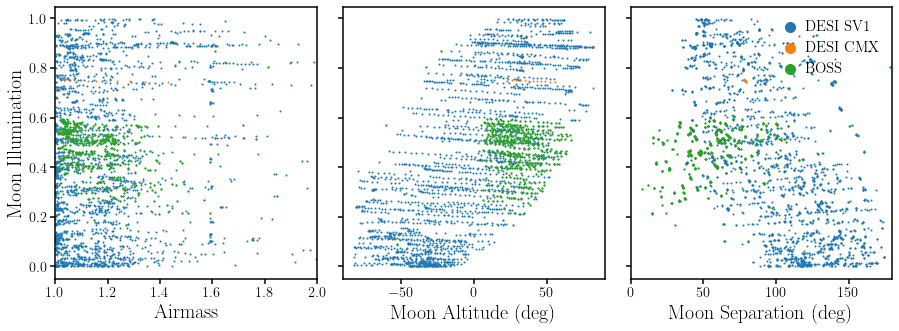

In [23]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)

sub.scatter(airmass, moon_frac, c='C0', s=1, label='DESI SV1', rasterized=True)
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], c='C1', s=1, label='DESI CMX', rasterized=True)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c='C2', s=1, label='BOSS', rasterized=True)

#sub.legend(loc='lower right', handletextpad=0, markerscale=10, fontsize=15)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('Moon Illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(moon_alt, moon_frac, c='C0', s=1, rasterized=True)
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], c='C1', s=1, rasterized=True)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c='C2', s=1, rasterized=True)

sub.set_xlabel(r'Moon Altitude (deg)', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(moon_sep, moon_frac, c='C0', s=1, label='DESI SV1', rasterized=True)
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], c='C1', s=1, label='DESI CMX', rasterized=True)
sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c='C2', s=1, label='BOSS', rasterized=True)
sub.set_xlabel('Moon Separation (deg)', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])
sub.legend(loc='upper right', handletextpad=0, markerscale=10, fontsize=15)

fig.subplots_adjust(wspace=0.1)
fig.savefig('figs/sky_obscond.pdf', bbox_inches='tight')

# get sky brightness at $5000\AA$
Smooth the sky spectrum and get surface brightness at $5000A$

In [24]:
from scipy.ndimage import gaussian_filter1d
def smooth_sky(sky, smoothing=100.): 
    return gaussian_filter1d(sky, smoothing) 

In [25]:
# sky brightness at 5000A for SV1
sv1_Iskies5000 = [] 
for Isky in Iskies: 
    Ismooth = smooth_sky(Isky, smoothing=100.)
    sv1_Iskies5000.append(np.interp(5000, wave, Ismooth))
    
# sky brightness at 5000A for CMX
cmx_Iskies5000 = []
for Isky in cmx_skies['sky_b']: 
    Ismooth = smooth_sky(Isky, smoothing=100.)
    cmx_Iskies5000.append(np.interp(5000, cmx_skies['wave_b'], Ismooth))
    
# sky brightness for BOSS
boss_Iskies5000 = []
for _w, Isky in zip(boss_skies['wave_b'], boss_skies['sky_b']): 
    Ismooth = smooth_sky(Isky, smoothing=800) # BOSS has 8x smaller binning
    boss_Iskies5000.append(np.interp(5000, _w, Ismooth))

compile observing conditions and sky brightnesses

In [26]:
airmass_all = np.concatenate([airmass, cmx_skies['airmass'], boss_skies['airmass']])
moon_frac_all = np.concatenate([moon_frac, cmx_skies['moon_ill'], boss_skies['moon_ill']])
moon_alt_all = np.concatenate([moon_alt, cmx_skies['moon_alt'], boss_skies['moon_alt']])
moon_sep_all = np.concatenate([moon_sep, cmx_skies['moon_sep'], boss_skies['moon_sep']])

Iskies5000_all = np.concatenate([sv1_Iskies5000, cmx_Iskies5000, boss_Iskies5000])

In [27]:
surveyses = np.concatenate([np.repeat('SV1', len(airmass)), np.repeat('CMX', len(cmx_skies['airmass'])), np.repeat('BOSS', len(boss_skies['airmass']))])
airmasses = np.concatenate([airmass, cmx_skies['airmass'], boss_skies['airmass']])
moonilles = np.concatenate([moon_frac, cmx_skies['moon_ill'], boss_skies['moon_ill']])
moonaltes = np.concatenate([moon_alt, cmx_skies['moon_alt'], boss_skies['moon_alt']])
moonsepes = np.concatenate([moon_sep, cmx_skies['moon_sep'], boss_skies['moon_alt']])

np.savetxt('dat/fig21_sky_exposures.dat', 
           np.vstack([surveyses, airmasses, moonilles, moonaltes, moonsepes, Iskies5000_all]).T, 
           fmt='%s', header='Sky exposures\n survey, airmass, moon illumination, moon altitude, moon separataion, Isky at 5000A [1e-17 ergs/s/cm^2/A/arcsec^2]')

# fit sky model
use polynomial regression to fit the sky surface brightness at $5000\AA$

In [28]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from itertools import chain, combinations_with_replacement

In [29]:
# train/test split
theta_train, theta_test, Isky_train, Isky_test = train_test_split(np.vstack([airmass_all, moon_frac_all, moon_alt_all, moon_sep_all]).T, np.log(Iskies5000_all), test_size=0.2, random_state=0)

In [30]:
regmodels_fsky, scores = [], [] 
for n_order in range(1, 8): 
    # we use Ridge instead of LinearRegression to regularize the coefficients
    regress_fsky = Pipeline([('poly', PolynomialFeatures(n_order)),
                             ('linear', Ridge(alpha=1., fit_intercept=False))]) 
    regress_fsky.fit(theta_train, Isky_train)
    regmodels_fsky.append(regress_fsky)
    
    # evaluate the model using crossvalidation
    _scores = cross_val_score(regress_fsky, theta_train, Isky_train, scoring="neg_mean_squared_error")
    #_scores = [-np.sum((Isky_train - regress_fsky.predict(theta_train))**2)]
    
    print('%i order: score=%f' % (n_order, -np.mean(_scores)))
    scores.append(-np.mean(_scores))
norder = np.argmin(scores)+1
regress_fsky = regmodels_fsky[np.argmin(scores)]

1 order: score=0.235025
2 order: score=0.151628


/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=8.96273e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.10872e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.07596e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


3 order: score=0.115054


/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.59195e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=5.68371e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=5.92477e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned mat

4 order: score=0.092801


/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.04942e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.5002e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.64699e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matr

5 order: score=0.076362


/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=7.72872e-30): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.38733e-30): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=6.37544e-30): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned mat

6 order: score=0.073994


/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.81473e-34): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.45037e-34): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.25142e-34): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned mat

7 order: score=0.084373


In [35]:
steps = regress_fsky.get_params()
skymodel_coeff = steps['linear'].coef_

In [36]:
print(norder)

6


In [37]:
skymodel_coeff

array([ 1.00552120e-02,  1.34739886e-02,  6.66537875e-03,  6.79462662e-02,
       -3.12178190e-02,  1.42883646e-02, -9.87811389e-04,  1.38453253e-02,
        4.99913148e-02, -2.03911360e-03, -2.37304285e-02,  1.56461651e-01,
       -4.31541924e-03, -4.47981071e-02, -1.18260792e-03,  1.89318575e-02,
       -8.33358280e-03, -8.88721103e-02,  8.22407155e-02, -4.01705702e-03,
       -6.07736053e-02, -2.38582135e-02,  5.18221684e-02,  7.28446943e-02,
       -1.29381937e-03, -4.17178370e-03,  2.11271919e-02, -8.08792528e-02,
        2.31166156e-02,  2.59330888e-02, -5.14519133e-03, -4.84323946e-04,
       -4.16622033e-04,  6.42141781e-04,  3.56100191e-05,  2.70410088e-02,
       -1.12503557e-02, -2.37301797e-02,  1.02784853e-01, -1.44776752e-03,
       -4.80957615e-02, -1.83049474e-01, -7.52468263e-02, -4.97667928e-02,
       -3.81720993e-03, -3.59536942e-03, -1.79576722e-02, -5.21339721e-02,
       -3.04435683e-02, -2.16242296e-02,  7.14623736e-03,  4.53766747e-04,
        4.39607298e-04, -

Lets see how well it reproduces the test sky brightnesses

In [38]:
def new_skymodel(airmass, moon_frac, moon_alt, moon_sep):
    ''' third degree polynomial regression sky model
    '''
    theta = np.atleast_2d(np.array([airmass, moon_frac, moon_alt, moon_sep]).T)

    combs = chain.from_iterable(combinations_with_replacement(range(4), i) for i in range(0, norder+1))
    theta_transform = np.empty((theta.shape[0], len(skymodel_coeff)))
    for i, comb in enumerate(combs):
        theta_transform[:, i] = theta[:, comb].prod(1)

    return np.exp(np.dot(theta_transform, skymodel_coeff.T))
    #return np.clip(np.dot(theta_transform, skymodel_coeff.T), 1.1282850428182252, None)

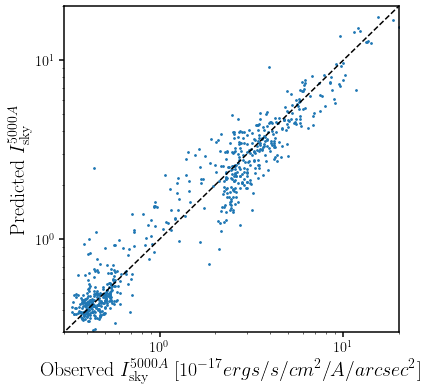

In [44]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(np.exp(Isky_test), new_skymodel(*theta_test.T), s=3)#, c=theta_test[:,i])
sub.plot([0., 40.], [0., 40.], c='k', ls='--')
sub.set_xlim([0.3, 20.])
sub.set_xscale('log')
sub.set_ylabel(r'Predicted $I_{\rm sky}^{5000A}$', fontsize=20)
sub.set_ylim([0.3, 20.])
sub.set_yscale('log')
#sub.set_yticks([0., 5., 10., 15., 20])
sub.set_xlabel(r'Observed $I_{\rm sky}^{5000A}$ [$10^{-17} ergs/s/cm^2/A/arcsec^2$]', fontsize=20) 
fig.savefig('figs/sky_pred.pdf', bbox_inches='tight')

In [36]:
np.savetxt('dat/fig21_skymodel_coeff.dat', skymodel_coeff, header='BGS sky model polynomial regression coefficients')